In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(699)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [17]:
expiry = 1
num_steps = 100
num_paths = 5
spot_price = 10
spot_price_frac = 0.3
rate = 0.05
vol = 0.25

In [1]:
plt.figure(figsize=(10, 8))
for d in data:
    plt.plot([i[0] for i in d], [i[1] for i in d])
plt.xlabel('Time');
plt.ylabel('Stock Price');

NameError: name 'plt' is not defined

In [18]:
def training_data(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
        
    Data = []
    dt = expiry/num_steps
    spot = spot_price
    vol2 = np.square(vol)
    mean2 = np.square(spot)
    var = mean2*np.square(spot_price_frac)
    
    log_mean = np.log(mean2) - 0.5*np.log(var + mean2) 
    log_stdev = np.sqrt(np.log(var/mean2 + 1))
    
    for _ in range(num_paths):
        data = []
        price = np.random.lognormal(log_mean, log_stdev)
        for step in range(num_steps):
            m = np.log(price) + (rate - vol2/2)*dt
            v = vol2*dt
            next_price = np.exp(np.random.normal(m, np.sqrt(v)))
            data.append((step, price, next_price))
            price = next_price
        Data.append(data)
    return Data

In [19]:
class Basisfunction():
    def __init__(self):
        pass

    def lauguaree(self, s, K, t, expiry):
        M = s/K
        e = np.exp(-M/2)
        diff = expiry - t
        return np.array([1, 
                         e, 
                         e*(1-M), 
                         e*(1-2*M+(M*M/2)), 
                         np.cos(np.pi*diff/(2*expiry)), 
                         np.log(diff) if diff>0 else 0, 
                         np.square(t/expiry)
                        ])

    def fourier(self, s, a):
        pass
    
    def identity(self, s, K, t, expiry):
        pass
        

In [167]:
class LSPI():
    def __init__(self, basis, k, eps=1e-2, option_type='put', seed=69):
        self.option_type = option_type # or 'call'
        
        self.eps = eps
        self.phi = basis
        self.k = k
        self.w = np.zeros((k, 1))
        self.P_inv = np.eye(self.k)/self.eps
        self.q = None
        self.Phi = None
        self.seed = seed
    
    def generate_data(self, expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike):

        np.random.seed(self.seed)
        
        self.data = training_data(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol)
        
        self.training_data = []
        for d in self.data:
            self.training_data += d
        self.dt = expiry/num_steps
        
        self.state = np.array([(i*self.dt, x) for i, x, _ in self.training_data])
        self.next_state = np.array([(i*self.dt, x) for i, _, x in self.training_data])
        self.non_terminal = np.array([i < num_steps-1 for i, _, _ in self.training_data])
        
        self.phi_s = np.array([self.phi(s, strike, t, expiry) for t, s in self.state])
    
        self.phi_next_s = np.array([self.phi(s, strike, t, expiry) for t, s in self.next_state])
        
        self.exer = None
        if self.option_type == 'put':
            self.exer = np.array([max(strike-s1, 0) for _, s1 in self.state])
        else:
            self.exer = np.array([max(s1-strike, 0) for _, s1 in self.state])
            
        
    def optimal_policy(self, s, strike, t, expiry):
        exer = max(strike-s, 0) if self.option_type=='put' else max(s-strike, 0)
        
        payoff = [(self.phi(s, strike, t, expiry)@self.w)[0], exer]
        return np.max(payoff), np.argmax(payoff), payoff

    def train(self, expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=1, r=0.03, plot=True, eps=1e-3, buff=0.0):
        self.w = np.ones((self.k, 1))
        self.loss = [np.linalg.norm(self.w)]
        self.generate_data(expiry-buff, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike)
        
        self.gamma = np.exp(-1*r)
        
        
            
        for _ in range(ITR):
            self.P_inv = np.eye(self.k)/eps
            self.q = np.zeros((self.k, 1))
            Q = self.phi_next_s@self.w
            C1 = self.non_terminal * (Q[:, 0] > self.exer)
#             print(C1[np.logical_not(self.non_terminal)], Q[np.logical_not(self.non_terminal)], self.exer[np.logical_not(self.non_terminal)])
            for i in range(len(self.training_data)):
                phi_1 = self.phi_s[i].reshape(-1, 1)
                 
                phi_2 = phi_1 - (C1[i]*self.gamma*self.phi_next_s[i]).reshape(-1, 1)
                
                temp = self.P_inv.T@phi_2
                
                self.P_inv -= self.P_inv@phi_1@temp.T / (1 + temp.T@phi_1)
                self.q += phi_1 * (1 - C1[i]) * self.exer[i] * self.gamma
            self.w = self.P_inv@self.q
            self.loss.append(np.linalg.norm(self.w))
        
        if plot:
            plt.figure(figsize=(10, 8))
            plt.title('Convergence of weights', fontsize=15)
            plt.ylabel(r'$|w|_2$', fontsize=15)
            plt.xlabel('Iterations', fontsize=15)
            plt.semilogy(self.loss)
        return self.w
                

In [168]:
expiry = 1
num_steps = 252
num_paths = 500
spot_price = 11
spot_price_frac = 0.01
rate = 0.05
vol = 0.2

strike = 10
option_type = 'put'
buff = 0.0

In [169]:
basis_class = Basisfunction()
basis = basis_class.lauguaree
os_problem = LSPI(basis, 7, eps=1e-3, option_type=option_type)

In [170]:
w1 = os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10, plot=False, eps=1e-3, buff=buff)
l1 = os_problem.loss

In [171]:
w2 = os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10, plot=False, eps=1e-6)
l2 = os_problem.loss

w3 = os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10, plot=False, eps=1e-9)
l3 = os_problem.loss

w4 = os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10, plot=False, eps=1e-12)
l4 = os_problem.loss

w5 = os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10, plot=False, eps=1e-15)
l5 = os_problem.loss

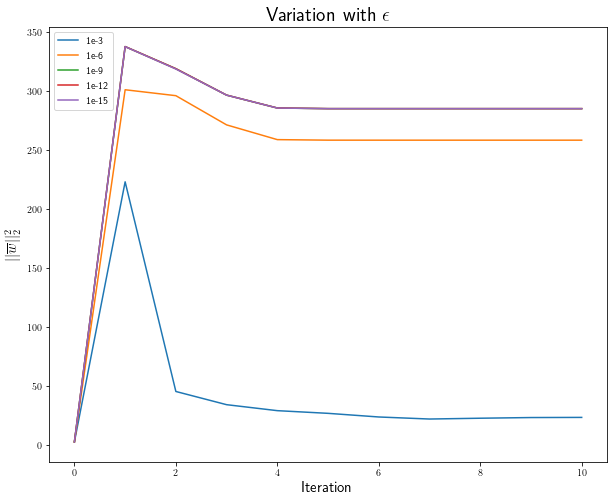

In [162]:
plt.figure(figsize=(10, 8))
plt.title(r'Variation with $\epsilon$', fontsize=20)
plt.plot(l1, label='1e-3')
plt.plot(l2, label='1e-6')
plt.plot(l3, label='1e-9')
plt.plot(l4, label='1e-12')
plt.plot(l5, label='1e-15')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel(r'$||\overline{w}||^2_2$', fontsize=15)
plt.savefig('figs/var_e.png', dpi=250)
plt.legend()

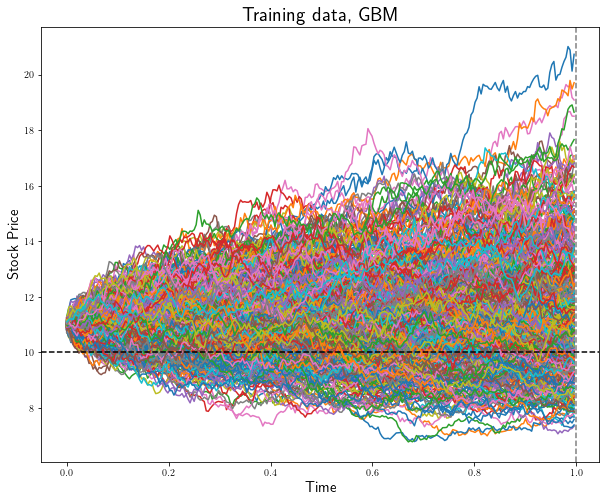

In [163]:
plt.figure(figsize=(10, 8))
plt.title('Training data, GBM', fontsize=20)
for d in os_problem.data:
    plt.plot([i[0]*expiry/num_steps for i in d], [i[1] for i in d])
plt.axhline(strike, color='black', linestyle='--')
plt.axvline(expiry, color='grey', linestyle='--')
plt.xlabel('Time', fontsize=15);
plt.ylabel('Stock Price', fontsize=15);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig('figs/gbm.png', dpi=300)

In [164]:
Ss_len = 300
Ts_len = 300

min_stock = 8
max_stock = strike+0.1
min_time = 0
max_time = 1

Ss = np.linspace(min_stock, max_stock, Ss_len)
Ts = np.linspace(min_time, max_time, Ts_len)

In [165]:
pol = np.zeros((Ss_len, Ts_len))
payoff = np.zeros((Ss_len, Ts_len))
for i in range(pol.shape[0]):
    for j in range(pol.shape[1]):
        payoff[i, j], pol[i, j], _ = os_problem.optimal_policy(Ss[i], strike, Ts[j], expiry)
# excersise_boundary = [Ss[np.where(pol[:, i]==1)[0][-1]] for i in range(Ts_len)]


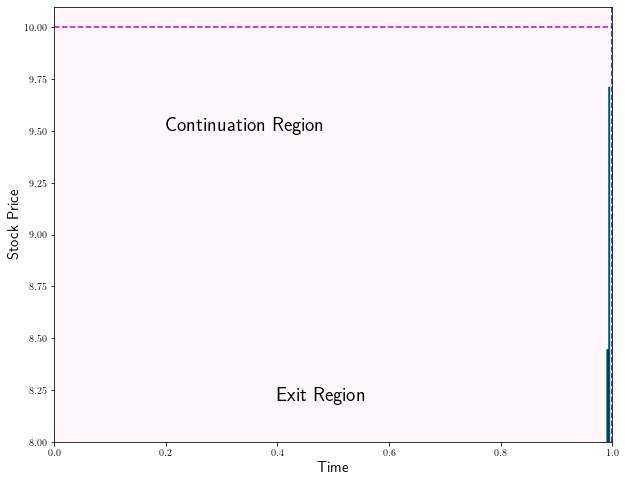

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

img = ax.imshow(pol, cmap='PuBuGn', origin='lower', extent=[min_time, max_time, min_stock, max_stock], aspect='auto')

# ax.plot(Ts, excersise_boundary, c='black', linewidth=5)
ax.axhline(strike, linestyle='--', color='m')
ax.axvline(expiry, linestyle='--', color='b')
# ax.axvline(expiry-buff, linestyle='--', color='r')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Stock Price', fontsize=15)
# ax.set_xticklabels(fontsize=10)
# ax.set_yticklabels(fontsize=10)
plt.text(0.2, 9.5,  'Continuation Region', fontsize=20)
plt.text(0.4, 8.2,  'Exit Region', fontsize=20)
plt.savefig('figs/gbm_train.png', dpi=300)

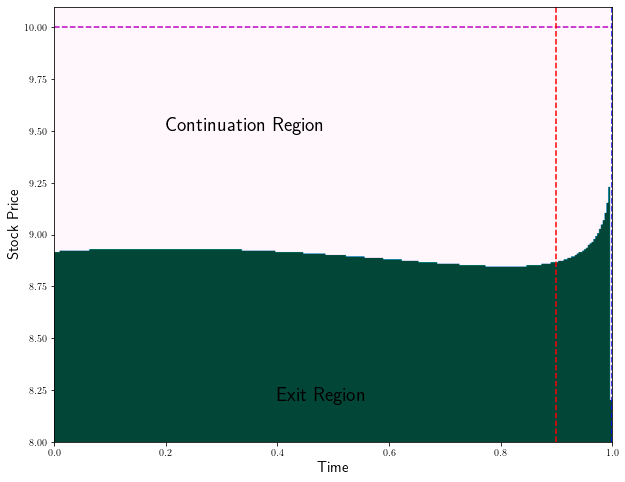

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

img = ax.imshow(pol, cmap='PuBuGn', origin='lower', extent=[min_time, max_time, min_stock, max_stock], aspect='auto')

# ax.plot(Ts, excersise_boundary, c='black', linewidth=5)
ax.axhline(strike, linestyle='--', color='m')
ax.axvline(expiry, linestyle='--', color='b')
ax.axvline(expiry-buff, linestyle='--', color='r')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Stock Price', fontsize=15)
# ax.set_xticklabels(fontsize=10)
# ax.set_yticklabels(fontsize=10)
plt.text(0.2, 9.5,  'Continuation Region', fontsize=20)
plt.text(0.4, 8.2,  'Exit Region', fontsize=20)
plt.savefig('figs/buf_train.png', dpi=300)

Text(0, 0.5, 'Stock Price')

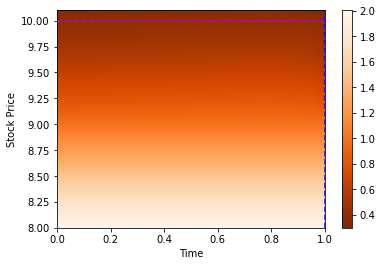

In [1152]:
fig, ax = plt.subplots(1, 1)

img = ax.imshow(payoff, cmap='Oranges_r', origin='lower', extent=[min_time, max_time, min_stock, max_stock], aspect='auto')
plt.colorbar(img)

ax.axhline(strike, linestyle='--', color='m')
ax.axvline(1.0, linestyle='--', color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')

# Finite-MDP with Binomial Option Pricing

In [1094]:
import sys
sys.path.append('/home/solomon/finance/RL-book')
from dataclasses import dataclass
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import Terminal, NonTerminal
from rl.policy import FiniteDeterministicPolicy
from rl.distribution import Constant, Categorical
from rl.finite_horizon import optimal_vf_and_policy
from rl.gen_utils.plot_funcs import plot_list_of_curves

In [1095]:
@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    def european_price(self, is_call: bool, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def dt(self) -> float:
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FiniteDeterministicPolicy[int, bool]]]:
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        return optimal_vf_and_policy(
            steps=[
                {NonTerminal(j): {
                    True: Constant(
                        (
                            Terminal(-1),
                            self.payoff(i * dt, self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (NonTerminal(j + 1), 0.): up_prob,
                            (NonTerminal(j), 0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FiniteDeterministicPolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].action_for[j] and
                         self.payoff(i * dt, self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, self.state_price(i, boundary_pt))
                )
        return ex_boundary

In [143]:
is_call= False
expiry_val= expiry
rate_val = rate
vol_val = vol
num_steps_val = 1000


opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)
time_pts, ex_bound_pts = zip(*ex_boundary)
label = "Put  Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

NameError: name 'OptimalExerciseBinTree' is not defined

Text(0, 0.5, 'Stock Price')

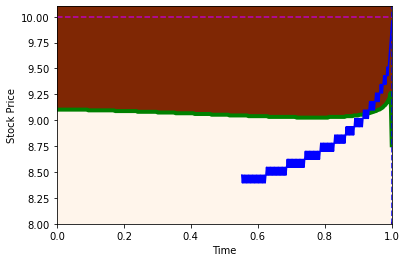

In [1153]:
fig, ax = plt.subplots(1, 1)

img = ax.imshow(pol, cmap='Oranges_r', origin='lower', extent=[min_time, max_time, min_stock, max_stock], aspect='auto')

ax.plot(Ts, excersise_boundary, c='green', linewidth=4)
ax.plot(time_pts, ex_bound_pts, c='blue')
ax.axhline(strike, linestyle='--', color='m')
ax.axvline(1.0, linestyle='--', color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')

# APPLE Stock data

In [282]:
data = pd.read_csv('dow.csv')

Text(0.5, 1.0, 'DOW')

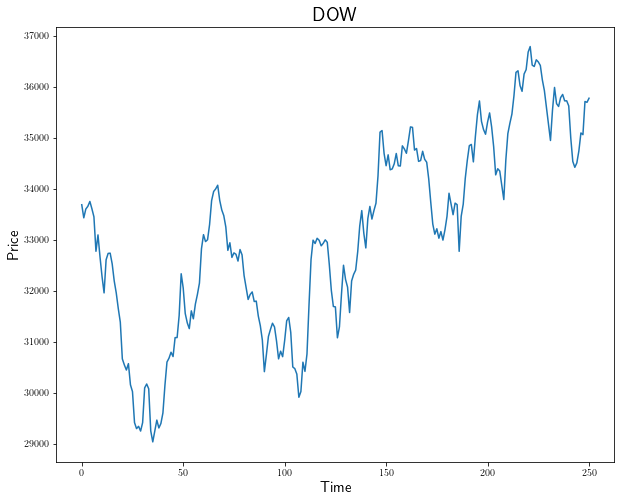

In [283]:
X = 0.5*(data.iloc[:,2] + data.iloc[:,3])
X = X.to_numpy()


plt.figure(figsize=(10, 8))
plt.plot(X)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.title('DOW', fontsize=20)

In [244]:
log_diff = np.diff(np.log(X))

vol = np.std(log_diff)
rate = np.mean(log_diff)

print("----- Estimatation of GBM -----")
print("rate = {}, volatility = {}".format(np.round(rate, 4), np.round(vol, 4)))

----- Estimatation of GBM -----
rate = 0.0002, volatility = 0.0102


In [261]:
expiry = 1
num_steps = X.shape[0]
num_paths = 10
spot_price = X[0]
spot_price_frac = 0.03
rate = 0.005
vol = 0.1

strike = 33000
option_type = 'put'
buff = 0.0

In [262]:
basis_class = Basisfunction()
basis = basis_class.lauguaree
os_problem = LSPI(basis, 7, eps=1e-3, option_type=option_type)

array([[ 23615.02092664],
       [ -9360.99476355],
       [-14107.47498559],
       [ 56978.24058958],
       [  1395.41422321],
       [   202.49855848],
       [   500.00208664]])

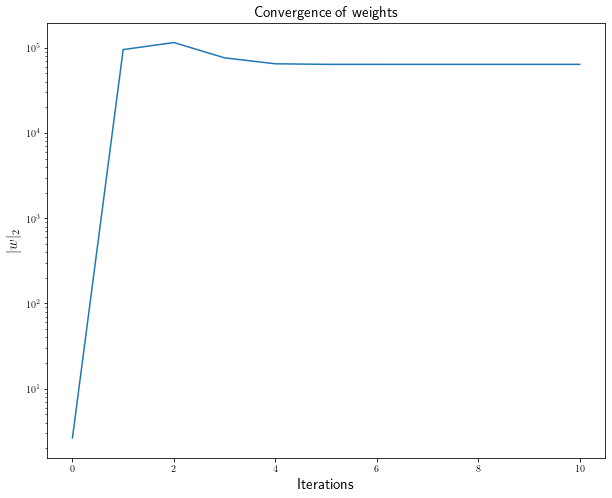

In [263]:
os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10, plot=True, eps=1e-2)

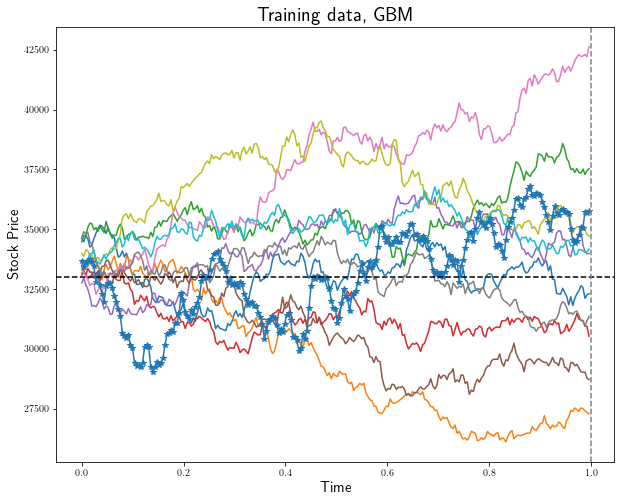

In [264]:
plt.figure(figsize=(10, 8))
plt.title('Training data, GBM', fontsize=20)
for d in os_problem.data:
    plt.plot([i[0]*expiry/num_steps for i in d], [i[1] for i in d])
plt.plot([i[0]*expiry/num_steps for i in d], X, '-*')
plt.axhline(strike, color='black', linestyle='--')
plt.axvline(expiry, color='grey', linestyle='--')
plt.xlabel('Time', fontsize=15);
plt.ylabel('Stock Price', fontsize=15);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig('figs/nasdaq_gbm.png', dpi=300)

In [284]:
p = []
pay = []
for i in range(X.shape[0]):
    x = os_problem.optimal_policy(X[i], strike, i*expiry/num_steps, expiry)
    p.append(x[1])
    pay.append(x[0])
p = np.array(p)
pay = np.array(pay)

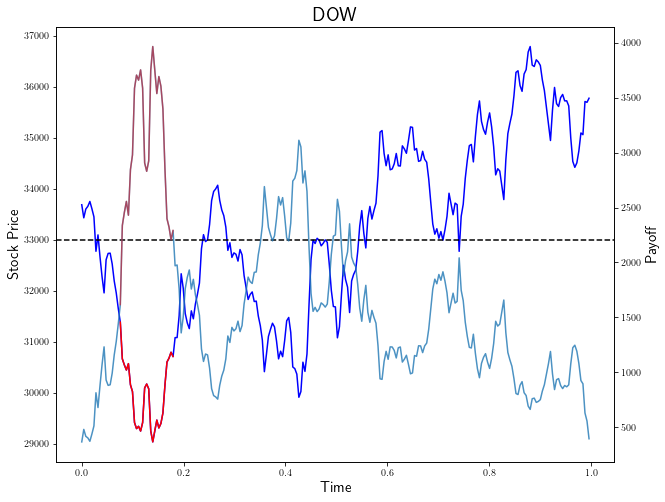

In [297]:
t = np.array([i*expiry/num_steps for i in range(X.shape[0])])

fig, ax1 = plt.subplots(figsize=(10, 8))

ax2 = ax1.twinx()

ax1.plot(t, X, 'b')
ax1.plot(t[p==1], X[p==1], 'r')
ax1.axhline(strike, linestyle='--', color='black')
ax2.plot(t, pay, alpha=0.8)
ax2.plot(t[p==1], pay[p==1], 'r', alpha=0.5)

ax1.set_xlabel('Time', fontsize=15)
ax1.set_ylabel('Stock Price', fontsize=15)
ax2.set_ylabel('Payoff', fontsize=15)
plt.title('DOW', fontsize=20)

plt.savefig('figs/dow_res.png', dpi=300)